### Goal: Analyze drug like traits of molecules that are mis-classified by nerual nets. Do they share drug like properties as defined by Lipinski's Rule of 5?

This is a cleaned up version of pcp_query.py (in the same directory). 

Will need to filter molecules by:
 - Smiles length < 400
 - Non-redundant IsomericSMILES
 - Salt forms

In [1]:
import pubchempy as pcp
import glob
import pandas as pd

### Populate a dictionary of CIDs:

In [2]:
glob_path = "/Users/ijmiller2/Desktop/UW_2018/For_Jesse/drug-class/Networks/data/fromPubChem/*txt"

tables_list=glob.glob(glob_path)
CID_dict = {}
for table in tables_list:
    #tableID = table.replace('.txt','')
    #tableID = tableID.replace('../data/','')
    tableID = table.split("/")[-1].rstrip(".txt")
    CID_dict[tableID] = []
    with open(table) as inf:
        for aline in inf.readlines():
            if aline.startswith('CID')==True:
                #cid = aline.replace('\n')
                CID_dict[tableID].append(aline.replace('\n','').replace('CID: ',''))

### Get SMILES for CIDs

Keep things with smiles length <400

In [3]:
smiles_dict = {}
cidslist = []
for key in CID_dict.keys():
    smiles_dict[key] = []
    prop_dict = pcp.get_properties('IsomericSMILES', CID_dict[key])
    for i in range(0, len(prop_dict)):
        if len(prop_dict[i]['IsomericSMILES'])<400:  #### only those under 200 char
            smiles_dict[key].append(prop_dict[i]['IsomericSMILES'])
            #cidslist.append(i) This isn't actually the CID

### Retrieve relevant chemical properties for all CIDs

In [4]:
property_list = ['MolecularWeight', 'HBondDonorCount', 'HBondAcceptorCount', 'XLogP', 'IsomericSMILES']
#This cid list is 12061
full_cidlist = [cid for cids in CID_dict.values() for cid in cids]
p = pcp.get_properties(property_list, full_cidlist, as_dataframe=True)

### Now filter by SMILES length, redundancy, and salt forms

Here's a block of Jesse's code from `standardize_data.ipynb` to remove the salt's from a SMILES formula.

In [6]:
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit import Chem

remover = SaltRemover()
cln_smiles_dict = {}

for key in smiles_dict.keys():
    tmplist = []
    for smiles in smiles_dict[key]:
        tmplist.append(Chem.MolToSmiles(remover(Chem.MolFromSmiles(smiles))))
    cln_smiles_dict[key] = list(set(tmplist))
        

In [ ]:
cln_smiles_dict

### Flatten on the non-redundant list of smiles

In [8]:
cln_smiles_list = [SMILES for SMILES_LIST in cln_smiles_dict.values() for SMILES in SMILES_LIST]

In [10]:
len(cln_smiles_list)

9887

In [11]:
len(set(cln_smiles_list))

8339

So there are some redundant formulas because they appear in multiple drug classes.

In [12]:
cln_smiles_list_nr = list(set(cln_smiles_list))

### Add a drug class and desalted SMILES columns to the property df

In [18]:
full_cidlist = [cid for cids in CID_dict.values() for cid in cids]

drug_class_for_df = []
for CID,row in p.iterrows():
    drug_classes = []
    for drug_class,CID_list in CID_dict.items():
        if str(CID) in CID_list:
            #print("{} in {}".format(CID,drug_class))
            drug_classes.append(drug_class)
    if len(drug_classes) > 1:
        drug_class_for_df.append("multi")
    else:
        drug_class_for_df.append(drug_classes[0])
    #print("\t".join([str(CID)] + drug_classes))

p['drug_class'] = drug_class_for_df

In [19]:
desalted_SMILES_list = []
for CID,row in p.iterrows():
    SMILES = row['IsomericSMILES']
    desalted_SMILES = Chem.MolToSmiles(remover(Chem.MolFromSmiles(SMILES)))
    desalted_SMILES_list.append(desalted_SMILES)
p['desalted_SMILES'] = desalted_SMILES_list

In [21]:
p.head()

,HBondAcceptorCount,HBondDonorCount,IsomericSMILES,MolecularWeight,XLogP,drug_class,desalted_SMILES
CID,,,,,,,
134715834,3,3,C[C@H](C=C[C@H](C1CC1)O)[C@H]2CC[C@@H]\3[C@@]2...,412.614,4.3,dermatologic,C=C1/C(=C/C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...
134695316,4,3,C[C@@H](C1CC[C@@H]2[C@@]1(CCCC2=C/C=C\3/C[C@H]...,418.618,3.5,multi,C=C1/C(=C\C=C2CCC[C@]3(C)C([C@H](C)OCCC(C)(C)O...
134694728,11,2,CC[C@@H]1/C=C(/C[C@@H](C[C@@H]([C@@H]2[C@H](CC...,810.463,3.8,multi,CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)[C@H]2O[C@...
134687786,8,2,C[C@@H]1C[C@H]2[C@@H]3C[C@@H](C4=CC(=O)C=C[C@@...,444.509,3.2,multi,C[C@@H]1C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@...
134129698,11,2,CC[C@H]1/C=C(/C[C@H](CC([C@@H]2[C@H](C[C@H]([C...,810.463,3.8,multi,CC[C@H]1/C=C(\C)C[C@@H](C)CC(OC)[C@H]2O[C@@](O...


Now filter based on SMILES length, multi class lable and non-redundant salt SMILES. The order might matter for desalted_SMILES...

In [23]:
CID_shortlist = []
desalted_list_NR = []
for CID,row in p.iterrows():
    
    isomericSMILES = row['IsomericSMILES']
    drug_class = row['drug_class']
    desalted_SMILES = row['desalted_SMILES']
    
    if len(isomericSMILES) < 400 and drug_class != "multi":
        
        #Manual check for redundancy
        if not desalted_SMILES in desalted_list_NR:
            
            CID_shortlist.append(CID)
            desalted_list_NR.append(desalted_SMILES)

In [25]:
len(desalted_list_NR)

7000

In [26]:
len(CID_shortlist)

7000

In [166]:
p.loc[CID_shortlist].head()

,HBondAcceptorCount,HBondDonorCount,IsomericSMILES,MolecularWeight,XLogP,drug_class,desalted_SMILES
CID,,,,,,,
134715834,3,3,C[C@H](C=C[C@H](C1CC1)O)[C@H]2CC[C@@H]\3[C@@]2...,412.614,4.3,dermatologic,C=C1/C(=C/C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...
131635427,22,2,CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCCCC.CCCC...,1803.834,NaN,dermatologic,CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCCCC.CCCC...
122130352,3,3,C[C@H](C=C[C@H](C1CC1)O)[C@H]2CC[C@@H]\3C2(CCC...,412.614,4.3,dermatologic,C=C1/C(=C\C=C2\CCCC3(C)[C@H]2CC[C@@H]3[C@H](C)...
122130146,6,2,CCCC(=O)O[C@@]1(CCC2C1(C[C@@H](C3C2CCC4=CC(=O)...,432.557,3.2,dermatologic,CCCC(=O)O[C@]1(C(=O)CO)CCC2C3CCC4=CC(=O)CCC4(C...
76960424,14,0,CCC1=C(C2=CC3=NC(=CC4=C(C(=C([N-]4)C5=C/C(=C(/...,1457.858,NaN,dermatologic,CCO/C([O-])=C1/C=C2C3=NC(=CC4=NC(=CC5=NC(=Cc6[...


In [39]:
len(p.loc[CID_shortlist].drop_duplicates(['desalted_SMILES']))

7000

Jesse's number is 6955 molecules, so maybe I should import from /Users/ijmiller2/Desktop/UW_2018/For_Jesse/drug-class/Networks/data_rmsalt_rmol/pics/12cls_rmsaltol.csv and create a subset dataframe from that. Should probably just generated a new CID shortlist from Jesse's file.

In [89]:
rmsaltol_df = pd.read_csv("../drug-class/Networks/data_rmsalt_rmol/pics/12cls_rmsaltol.csv")

In [ ]:
jesses_CID_list = []
missing_SMILES = []

count = 0
for index,row in rmsaltol_df.sort_values('smiles').iterrows():
    jesses_SMILES = row['smiles']
    count += 1
    no_match = True
    for CID,row2 in p.loc[CID_shortlist].sort_values('desalted_SMILES').iterrows():
        desalted_SMILES = row2['desalted_SMILES']
        if jesses_SMILES == desalted_SMILES:
            print(count,jesses_SMILES,desalted_SMILES)
            jesses_CID_list.append(CID)
            no_match = False
            continue
    if no_match:
        missing_SMILES.append(jesses_SMILES)
           

### Write the missing SMILES out to a file for later use

In [165]:
pd.DataFrame(missing_SMILES, columns = ['smiles']).to_csv("data/missing_smiles.tsv",sep="\t",index=False)

### Which smiles are missing and to what drug class do they belong?

In [157]:
rmsaltol_df
for SMILES in missing_SMILES:
    for index,row in rmsaltol_df.sort_values('smiles').iterrows():
        if SMILES == row['smiles']:
            print("{}\t{}".format(SMILES,row['class']))

C=CC1=C(C)c2cc3[n-]c(cc4[n-]c(cc5nc(cc1n2)C(C)=C5C=C)c(C)c4CCC(=O)O)c(CCC(=O)O)c3C	dermatologic
C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=C5CCC(=O)O)C(CCC(=O)O)=C4C)c(C)c3C=C	dermatologic
C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=C5CCC(=O)[O-])C(CCC(=O)[O-])=C4C)c(C)c3C=C	dermatologic
C=Cc1c(C)c2cc3nc(cc4[nH]c(cc5nc(cc1[nH]2)C(C)=C5CCC(=O)O)c(CCC(=O)OC)c4C)[C@@]1(C)C3=CC=C(C(=O)OC)[C@H]1C(=O)OC	dermatologic
C=Cc1c(C)c2cc3nc(cc4[nH]c(cc5nc(cc1[nH]2)C1(C)C5=CC=C(C(=O)OCC)C1C(=O)OCC)c(C)c4CCC(=O)O)C(CCC(=O)O)=C3C	dermatologic
CC1=C(CCC(=O)O)c2cc3nc(cc4[nH]c(cc4C)cc4[nH]c(cc1n2)cc4C)C(C)=C3CCC(=O)O	dermatologic
CC1=C(CCC(=O)O)c2cc3nc(cc4[nH]c(cc5[nH]c(cc1n2)c(C)c5C(C)O)c(C)c4C(C)O)C(C)=C3CCC(=O)O	dermatologic
CC1=C(CCC(=O)[O-])c2cc3nc(cc4[nH]c(cc5[nH]c(cc1n2)c(C)c5C(C)O)c(C)c4C(C)O)C(C)=C3CCC(=O)[O-]	dermatologic
CCc1c(CC)c2cc3nc(cnc4cc(OCCOCCOCCOC)c(OCCOCCOCCOC)cc4ncc4nc(cc1[n-]2)C(CCCO)=C4C)C(C)=C3CCCO.[Lu+3]	dermatologic
CCc1c(CC)c2cc3nc(cnc4cc(OCCOCCOCCOC)c(OCCOCCOCCOC)cc4ncc4n

### Write the output for analysis in R (`CID_properties.R`)

In [96]:
p.loc[CID_shortlist].to_csv("CID_properties_nr.csv", na_rep="NA", quoting=1)
p.loc[jesses_CID_list].to_csv("CID_properties_nr.csv", na_rep="NA", quoting=1)

### Get sample numbers for each of these features 

Mostly for XLogP since there are many missing values there.

In [112]:
sample_size_dict = {}
for CID,row in p.loc[jesses_CID_list].iterrows():
    drug_class = row['drug_class']
    XLogP = row['XLogP']
    
    #Initialize the drug class dict
    if not drug_class in sample_size_dict:
        sample_size_dict[drug_class] = {}
        if pd.isnull(XLogP):
            sample_size_dict[drug_class]['XLogP'] = {'nan':1}
        else:
            sample_size_dict[drug_class]['XLogP'] = {'actual_values':1}
    
    else:
        if pd.isnull(XLogP):
            if not 'nan' in sample_size_dict[drug_class]['XLogP']:
                sample_size_dict[drug_class]['XLogP'] = {'nan':1}
            else:
                sample_size_dict[drug_class]['XLogP']['nan'] += 1
        else:
            if not 'actual_values' in sample_size_dict[drug_class]['XLogP']:
                sample_size_dict[drug_class]['XLogP'] = {'actual_values':1}
            else:
                sample_size_dict[drug_class]['XLogP']['actual_values'] += 1
    
sample_size_dict

{'antiinfective': {'XLogP': {'actual_values': 4}},
 'antiinflammatory': {'XLogP': {'actual_values': 1}},
 'antineoplastic': {'XLogP': {'actual_values': 2}},
 'cardio': {'XLogP': {'actual_values': 1}},
 'cns': {'XLogP': {'actual_values': 1}},
 'dermatologic': {'XLogP': {'nan': 8}},
 'gastrointestinal': {'XLogP': {'nan': 5}},
 'hematologic': {'XLogP': {'nan': 2}},
 'lipidregulating': {'XLogP': {'actual_values': 8}},
 'reproductivecontrol': {'XLogP': {'nan': 7}},
 'respiratorysystem': {'XLogP': {'nan': 2}},
 'urological': {'XLogP': {'actual_values': 3}}}

### Which features and drug classes are missing values?

In [116]:
feature_list = ['MolecularWeight', 'HBondDonorCount', 'HBondAcceptorCount', 'XLogP']
feature = "XLogP"
for feature in feature_list:
    missing_value_dict = {}
    print(feature)
    for CID,row in p.loc[jesses_CID_list].iterrows():
        drug_class = row['drug_class']
        feature_of_interest = row[feature]

        if pd.isnull(feature_of_interest):
            if not drug_class in missing_value_dict:
                missing_value_dict[drug_class] = 1
            else:
                missing_value_dict[drug_class] += 1
    print(missing_value_dict)

MolecularWeight
{}
HBondDonorCount
{}
HBondAcceptorCount
{}
XLogP
{'dermatologic': 35, 'antiinfective': 748, 'gastrointestinal': 99, 'cns': 430, 'antiinflammatory': 89, 'reproductivecontrol': 45, 'hematologic': 98, 'cardio': 265, 'antineoplastic': 252, 'lipidregulating': 37, 'respiratorysystem': 61, 'urological': 14}


So there are only missing values in XLogP feature space.

### What's the general spread?

In [126]:
feature_list = ['MolecularWeight', 'HBondDonorCount', 'HBondAcceptorCount', 'XLogP']
feature_dict = {}
for feature in feature_list:
   
    value_dict = {}
    print(feature)
    for CID,row in p.loc[jesses_CID_list].iterrows():
        drug_class = row['drug_class']
        feature_of_interest = row[feature]

        if not pd.isnull(feature_of_interest):
            if not drug_class in value_dict:
                value_dict[drug_class] = 1
            else:
                value_dict[drug_class] += 1
    print(value_dict)
    feature_dict[feature] = value_dict
    
for drug_class,counts in feature_dict['XLogP'].items():
    MW_counts = feature_dict['MolecularWeight'][drug_class]
    print("{}\t{}\t{}".format(drug_class,counts,MW_counts))

MolecularWeight
{'dermatologic': 108, 'antiinfective': 2396, 'gastrointestinal': 255, 'cns': 1141, 'antiinflammatory': 372, 'cardio': 787, 'hematologic': 268, 'reproductivecontrol': 148, 'antineoplastic': 1174, 'lipidregulating': 164, 'respiratorysystem': 100, 'urological': 22}
HBondDonorCount
{'dermatologic': 108, 'antiinfective': 2396, 'gastrointestinal': 255, 'cns': 1141, 'antiinflammatory': 372, 'cardio': 787, 'hematologic': 268, 'reproductivecontrol': 148, 'antineoplastic': 1174, 'lipidregulating': 164, 'respiratorysystem': 100, 'urological': 22}
HBondAcceptorCount
{'dermatologic': 108, 'antiinfective': 2396, 'gastrointestinal': 255, 'cns': 1141, 'antiinflammatory': 372, 'cardio': 787, 'hematologic': 268, 'reproductivecontrol': 148, 'antineoplastic': 1174, 'lipidregulating': 164, 'respiratorysystem': 100, 'urological': 22}
XLogP
{'dermatologic': 73, 'antiinfective': 1648, 'gastrointestinal': 156, 'cns': 711, 'antiinflammatory': 283, 'reproductivecontrol': 103, 'hematologic': 170, 

### Could cluster by features

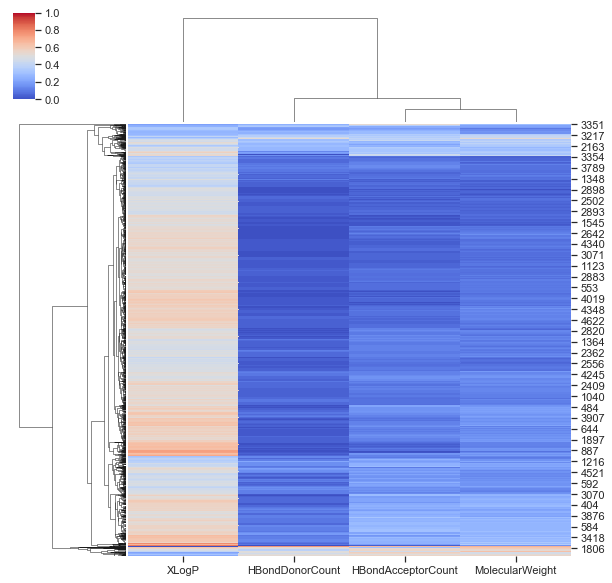

In [153]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sb

feature_df = p.loc[CID_shortlist][['HBondAcceptorCount', 'HBondDonorCount','MolecularWeight', 'XLogP', 'drug_class']].dropna()

feature_range = (0,1)
scaler = MinMaxScaler(feature_range=feature_range)
#feature_df_scaled = pd.DataFrame(scaler.fit_transform(feature_df), columns=feature_df.columns)
#sb.clustermap(feature_df_scaled[feature_df_scaled.columns[:-1]], cmap=sb.color_palette("coolwarm", 100))#, row_colors=feature_df_scaled['drug_class'])

sb.clustermap(feature_df_scaled[feature_df.columns[:-1]], standard_scale=1, cmap=sb.color_palette("coolwarm", 100))#, row_colors=feature_df['drug_class'])

In [76]:
len(feature_df_scaled)

4768

Would be nice to see another color for drug class. There seem to be large swaths of dark values. Maybe some other time of transformation is necessary to due a fair comparison/clustering like this. I wonder what a density plot of this scaled columns would look like.

/Users/ijmiller2/anaconda3/envs/drug-class/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


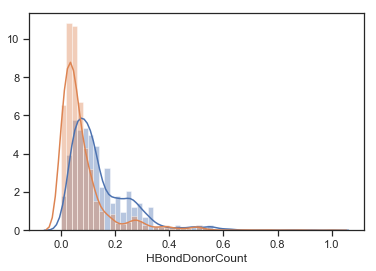

In [102]:
ax = sb.distplot(feature_df_scaled['HBondAcceptorCount'])
ax = sb.distplot(feature_df_scaled['HBondDonorCount'])

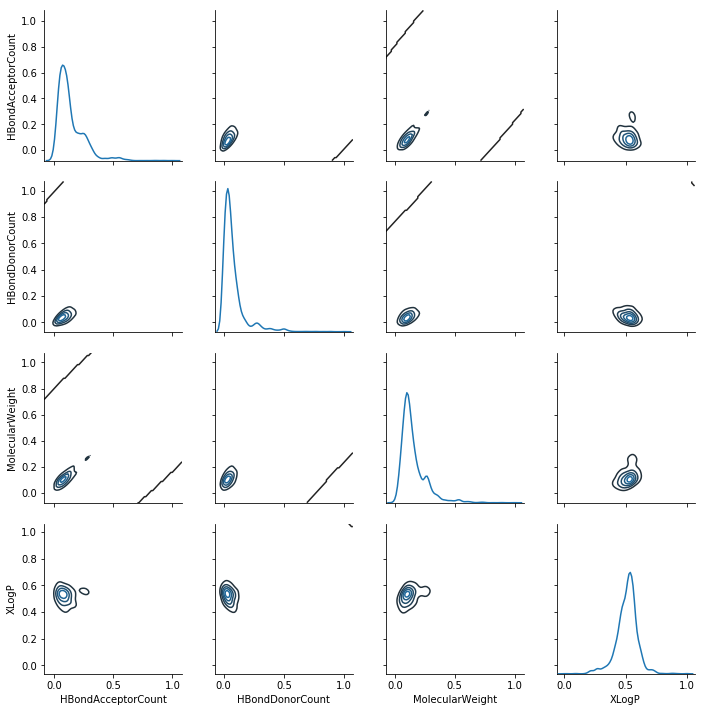

In [84]:
g = sb.PairGrid(feature_df_scaled)
g.map_diag(sb.kdeplot)
g.map_offdiag(sb.kdeplot, n_levels=5)

/Users/ijmiller2/anaconda3/envs/drug-class/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


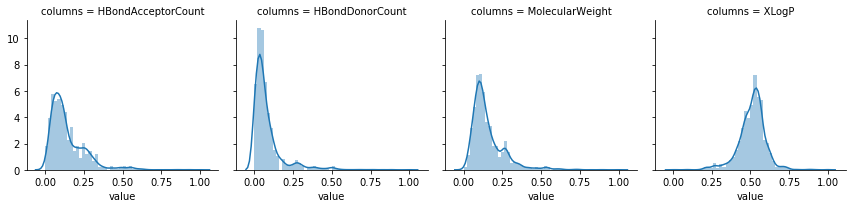

In [83]:
dfm = feature_df_scaled.melt(var_name='columns')
g = sb.FacetGrid(dfm, col='columns')
g = (g.map(sb.distplot, 'value'))

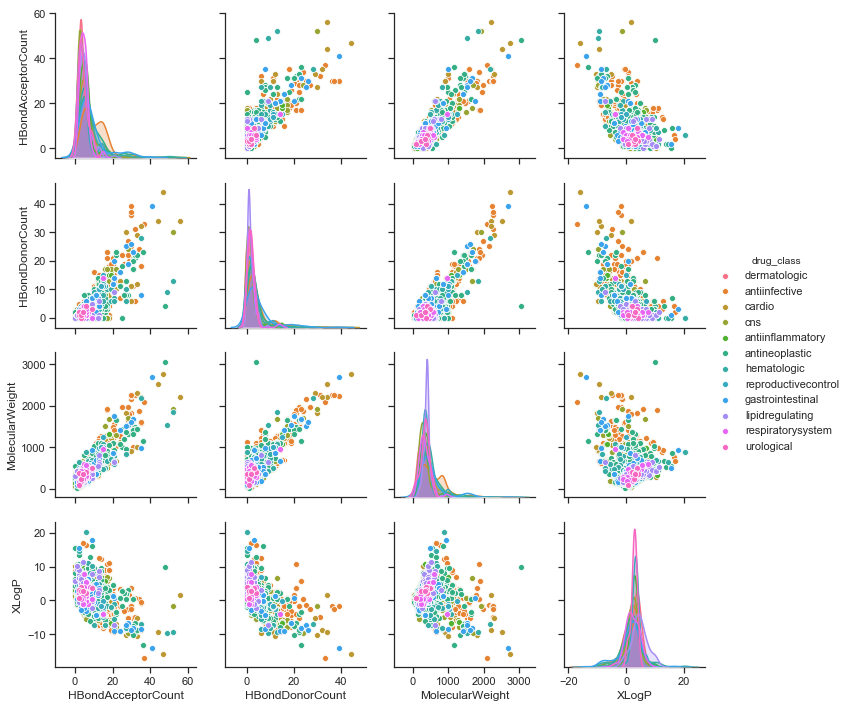

In [160]:
df = p.loc[CID_shortlist][['HBondAcceptorCount', 'HBondDonorCount','MolecularWeight', 'XLogP','drug_class']].dropna()
ax = sb.pairplot(df, hue="drug_class")
#fig = ax.get_figure()
ax.savefig('drug-class_pairplot.pdf', format="pdf")